In [97]:
from collections import defaultdict
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from scipy.stats import norm, linregress
import matplotlib.pyplot as plt
import sys
import time
import pdb
from itertools import chain, product
import itertools
import string

import multiprocessing as mp
import queue

from scipy.sparse import csr_matrix


from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, train_test_split
from dtaidistance import dtw

main_path = os.path.abspath(os.path.join(os.path.dirname("./Untitled.ipynb"), '..'))


In [98]:
def load_numpy_dataset(data_path, file_base):
    dataset = np.load(os.path.join(data_path, file_base % "d"), allow_pickle=True)
    for i in range(dataset.size):
        dataset[i] = preprocessing.scale(dataset[i])
    times = np.load(os.path.join(data_path, file_base % "t"), allow_pickle=True)
    labels = np.load(os.path.join(data_path, file_base % "l"), allow_pickle=True)
    return dataset, times, labels.astype(int), len(dataset)

def load_numpy_dataset2(data_path, file_base, normalize=True):
    dataset = np.load(os.path.join(data_path, file_base % "dataset"), allow_pickle=True)
    for i in range(dataset.size):
        dataset[i] = preprocessing.scale(dataset[i])
    times = np.load(os.path.join(data_path, file_base % "times"), allow_pickle=True)
    labels = np.load(os.path.join(data_path, file_base % "labels"), allow_pickle=True)
    return dataset, times, labels.astype(int), len(dataset)

def predict_class_cosine(similarity_matrix, train_label, n_train, n_test):
    pred_labels = []
    for j in range(n_test):
        dmax = -np.inf
        label = -1
        for i in range(n_train):
            if similarity_matrix[i][j] > dmax:
                dmax = similarity_matrix[i][j]
                label = train_label[i]
        pred_labels.append(label)
    return pred_labels

def predict_class_euclidean(similairty_matrix, train_label, n_train, n_test):
    pred_labels = []
    for j in range(n_test):
        dmin = np.inf
        label = -1
        for i in range(n_train):
            if similairty_matrix[i][j] < dmin:
                dmin = similairty_matrix[i][j]
                label = train_label[i]
        pred_labels.append(label)
    return pred_labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()

In [254]:

def mean_value_bp(values, alphabet_size, strategy="uniform"):
    if strategy == "uniform":
        values_min = np.min(values)
        values_max = np.max(values)
        return np.linspace(values_min, values_max, alphabet_size+1)[1:-1]
    elif strategy == "normal":
#         print("before")
        mean = np.mean(values)
        std = np.std(values)
        if std == 0:
            return np.linspace(mean, mean, alphabet_size+1)[1:-1]
        else:
            return norm.ppf(np.linspace(0, 1, alphabet_size+1)[1:-1], mean, std)

    
def slope_bp(alphabet_size):
    values_min = -np.pi/4
    values_max = np.pi/4
    return np.linspace(values_min, values_max, alphabet_size+1)[1:-1]

def min_max_bp(values, alphabet_size):
    diff = np.abs(np.max(values) - np.min(values))
    return np.linspace(0, diff, alphabet_size+1)[1:-1]


class DocumentTimeSeries(object):
    def __init__(self, alph_size=4, word_length=2, window=100, alphabet=["a", "b", "c", "d"], 
                 feature="mean", bp_strategy="uniform", tol=2, global_break_points=False, threshold=2,
                empty_handler="special_character"):
        self.word_length=word_length
        self.alph_size=alph_size
        self.window=window
        self.feature = feature
        self.bp_strategy=bp_strategy
        self.tol = tol
        self.global_break_points = global_break_points
        self.threshold = threshold
        self.bp = None
        self.ini_time = 0
        self.end_time = window
        self.alphabet = alphabet
        self.alphabet_inverse = {x: i for i, x in enumerate(self.alphabet)}
        self.empty_handler = empty_handler
    
    def get_break_points(self, ts_data):
        if self.feature == "mean":
            return mean_value_bp(ts_data, self.alph_size, strategy=self.bp_strategy)
        elif self.feature == "trend":
            return slope_bp(self.alph_size)
        elif self.feature == "minmax":
            return min_max_bp(ts_data, self.alph_size)
        elif self.feature == "trend_value":
            k = self.alph_size // 2
            return [mean_value_bp(ts_data, self.alph_size - k, strategy=self.bp_strategy),
                   slope_bp(k)]
        
    def gen_document(self, ts_data, ts_times, strategy="all_sub_sequence", **kwargs):
        if strategy == "all_sub_sequence":
            return self.transform_all_sub_sequence(ts_data, ts_times)
        else:
            raise ValueError("not implemented")
        
    def transform_all_sub_sequence(self, ts_data, ts_time):
        doc = ""
        i = 0
        j = 1
        n = ts_data.size
        ini_obs, end_obs = ts_time[0], ts_time[n-1]
        if self.global_break_points or self.word_length == 1:
            self.bp = self.get_break_points(ts_data)
#             if self.feature == "minmax":
#                 print(self.bp)
        while i < n - self.tol:
            self.ini_time, self.end_time = ts_time[i], ts_time[i] + self.window
            while ts_time[j]  < self.end_time:
                if j == n-1:
                    break
                j += 1
#             if self.window == 100:
#                 print(self.ini_time, self.end_time, i, j)
            if j - i > self.tol * self.word_length:
                if not self.global_break_points and self.word_length > 1:
                    self.bp = self.get_break_points(ts_data[i:j])
#                 if self.window == 100:
#                     print(i, j, self.bp)
                word = self.sequence_to_word(ts_data, ts_time, i, j)
#                 print(word, type(word))
                if word.count("#") <= self.threshold:
                    doc += word + " "
            i += 1
        return doc[:-1] if len(doc) > 1 else doc
    
    def sequence_to_word(self, ts_data, ts_time, i, j):
        if self.word_length > 1:
            seg_limits = np.linspace(self.ini_time, self.end_time, self.word_length + 1)[1:]
            
            word = ''
            ii = i
            jj = i+1
            for k in range(self.word_length):
                while ts_time[jj] < seg_limits[k]:
                    if jj == j:
                        break
                    jj += 1
#                 if self.window == 100:
#                     print(k, ii, jj)
                if jj - ii > self.tol:
                    val = self.segment_to_char(ts_data, ts_time, ii, jj)
                else:
                    val = "#"
                word += val
                ii = jj
        else:
            word = self.segment_to_char(ts_data, ts_time, i, j)
            
        if self.empty_handler == "special_character":
            return word
        
        elif self.empty_handler == "all_posibilities":
            raise ValueError("notimplemented")
            
        elif self.empty_handler == "linear_interpolation":
            l_w = len(word)
            if l_w == 1:
                if word == '#':
                    return " ".join(self.alphabet)
                else:
                    return word
            if l_w == 2:
                if word == "##":
                    return ' '.join([a + b for a in self.alphabet for b in self.alphabet])
                elif word[0] == '#':
                    return word[1] + word[1]
                elif word[1] == "#":
                    return word[0] + word[0]
                else:
                    return word
            else:
                word = list(word)
                if all([x == '#' for x in word]):
                    return list(map(''.join,
                              chain.from_iterable(product(self.alphabet,
                                                         repeat=l_w) for i in range(1))))
                if word[0] == '#':
                    kk = 1
                    while word[kk] == '#':
                        kk += 1
                    ll = kk
                    while ll >= 0:
                        word[ll] = word[kk]
                        ll -= 1
                if word[-1] == '#':
                    kk = l_w - 2
                    while word[kk] == '#':
                        kk -= 1
                    ll = kk
                    while ll < l_w:
                        word[ll] = word[kk]
                        ll += 1
                if any([x == '#' for x in word]):
                    for kk in range(1, l_w-1):
                        if word[i] == '#':
                            prev = self.alphabet_inverse[word[kk-1]]
                            post = self.alphabet_inverse[word[kk+1]]
                            middle = int(round((prev + post) / 2))
                            word[kk] = self.alphabet[middle]
                return ''.join(word)
                
            return word
        
        elif self.epty_handler == "special1":
            l_w = len(word)
            if l_w == 1:
                if word == '#':
                    return " ".join(self.alphabet)
                else:
                    return word
            if l_w == 2:
                if word == "##":
                    return ' '.join([a + b for a in self.alphabet for b in self.alphabet])
                elif word[0] == '#':
                     return ' '.join([a + word[1] for a in self.alphabet])
                elif word[1] == "#":
                    return ' '.join([word[0] + a for a in self.alphabet])
                else:
                    return word
                
            if l_w > 2:
                word = list(word)
                if all([x == '#' for x in word]):
                    return list(map(''.join,
                              chain.from_iterable(product(self.alphabet,
                                                         repeat=l_w) for i in range(1))))
                
                for kk in range(1, l_w-1):
                    if word[kk] == "#":
                        middle = (self.alphabet_inverse[word[kk+1]] - self.alphabet_inverse[word[kk-1]]) / 2
                        word[kk] = self.alphabet[int(round(middle))]
                new_word = [''.join(word)]
                if word[0] == '#':
                    new_word = [a + w[1:] for w in new_word for a in self.alphabet]
                if l_w > 1 and word[-1] == '#':
                    new_word = [w[:-1] + a for w in new_word for a in self.alphabet]
                return " ".join(new_word)
            
        
    def segment_to_char(self, ts_data, ts_time, i, j):
        if self.feature == "mean":
            mean = np.mean(ts_data[i:j])
#             if self.window == 100:
#                 print(mean)
            return self.alphabet[np.digitize(mean, self.bp)]
        elif self.feature == "trend":
            slope, _,_,_,_ = linregress(ts_time[i:j], ts_data[i:j])
            trend = np.arctan(slope)
            return self.alphabet[np.digitize(trend, self.bp)]
        
        elif self.feature == "minmax":
            diff = np.abs(np.max(ts_data[i:j]) - np.min(ts_data[i:j]))
#             print(diff)
            return self.alphabet[np.digitize(diff, self.bp)]
        elif self.feature == "trend_value":
            mean = np.mean(ts_data[i:j])
            slope, _,_,_,_ = linregress(ts_time[i:j], ts_data[i:j])
            trend = np.arctan(slope)
            k = self.alph_size // 2
            tv2 = self.alphabet[k:][np.digitize(mean, self.bp[0])]
            tv1 = self.alphabet[:k][np.digitize(trend, self.bp[1])]
#             print("trend:", tv1, ", value:", tv2)
            return tv2 + tv1
        else:
            raise ValueError("feature '%s' unknown" % self.feature)
        
        
def document_numerosity_reduction(doc):
    doc_arr = doc.split()
    new_doc = [doc_arr[0]]
    pword = doc_arr[0]
    for i in range(1,len(doc_arr)):
        if pword != doc_arr[i]:
            new_doc.append(doc_arr[i])
            pword = doc_arr[i]
    return " ".join(new_doc)

# Generalized application multi-window, multi-word, multi-feature

application for single band

In [272]:
def generalized_document_transform(dataset, times, full_alphabet, alph_size=8, word_length=[2], 
                                   windows=[800, 400, 200, 100, 50, 25],
                                   feature=["mean"], thresholds=None, 
                                   empty_handler="special_character",
                                   tol=3, bp_strategy="uniform", global_break_point=False,
                                  numerosity_reduction=False):
    if thresholds is None:
        thresholds = [0] * len(word_length)
    full_doc = defaultdict(list)
    i = 0
    fail = True
    for win in windows:
        for thrs, wl in zip(thresholds, word_length):
            for fea in feature:
                alphabet = full_alphabet[i:i+alph_size]
                doc_ts = DocumentTimeSeries(alph_size=alph_size, word_length=wl,
                                           window=win, alphabet=alphabet, feature=fea,
                                           bp_strategy=bp_strategy, threshold=thrs,
                                           global_break_points=global_break_point, 
                                            empty_handler=empty_handler)
                doc = doc_ts.gen_document(dataset, times)
                if len(doc) > 0:
                    fail = False
                    if numerosity_reduction:
                        doc = document_numerosity_reduction(doc)
                full_doc["windows"].append(win)
                full_doc["word_length"].append(wl)
                full_doc["threshold"].append(thrs)
                full_doc["feature"].append(fea)
                full_doc["alphabet"].append(alphabet)
                full_doc["doc"].append(doc)
                i += alph_size
    if fail:
        print("Fail")
                
    return full_doc


def merge_corpus_dict(corpus_dict):
    corpus = []
    for i in range(len(corpus_dict)):
        docs = corpus_dict[i]["doc"]
        corpus.append(" ".join(docs))
    return corpus


def get_full_alphabet(max_alph_size):
    letters = list(string.ascii_letters)
    if max_alph_size > len(letters):
        N = max_alph_size // len(letters) + 1
        numbers = np.arange(N) + 1
        alphabet = [str(numbers[i]) + x for i in range(N) for x in letters]
    else:
        alphabet = letters
    return alphabet
    
def get_vocabulary(full_alphabet, alph_size, windows, feature, word_length, thresholds):
    l = 0
    vocabulary = []
    for i in range(len(windows)):
        for  j in range(len(feature)):
            for k in range(len(word_length)):
                used_alphabet = full_alphabet[l:l+alph_size]
                if thresholds[k] > 0:
                    used_alphabet.append('#')
                if feature[j] != 'trend_value':
                    vocabulary.extend(list(map(''.join,
                              chain.from_iterable(product(used_alphabet,
                                                         repeat=word_length[k]) for i in range(1)))))
                else:
                    divider = alph_size // 2
                    new_alphabet  = [a + b for a in used_alphabet[:divider] for b in used_alphabet[divider:]]
                    vocabulary.extend(list(map(''.join,
                                              chain.from_iterable(product(new_alphabet,
                                                                         repeat=word_length[k]) for _ in [0]))))
                l += alph_size
    return np.unique(vocabulary)


def compute_centroids(vectors, labels):
    classes = np.unique(labels)
    n_classes = len(classes)
    centroids = np.zeros((n_classes, vectors.shape[1]))
    class_counter = np.zeros(n_classes)
    for i in range(len(labels)):
        idx = np.where(labels[i] == classes)[0]
        centroids[idx] += vectors[i]
        class_counter[idx] += 1
    
    for i in range(n_classes):
        centroids[i] /= class_counter[i]
        
    return centroids, classes

def dataset_to_corpus_worker(dataset, times, full_alphabet, lock, idx_queue, out_queue, **kwargs):
    try:
#         print("========== start worker '%s' ==========" % mp.current_process().name)
        while True:
            try:
                lock.acquire()
                i = idx_queue.get_nowait()
                n = len(dataset)
            except queue.Empty:
                lock.release()
                break
            else:
                lock.release()
                if i > 0 and i % 10 == 0:
                    print("processed %d/%d (worker '%s')" % (i, n, mp.current_process().name), end="\r")
                doc = generalized_document_transform(dataset[i], times[i], full_alphabet,  
                                                     alph_size=kwargs.get("alph_size"), 
                                                     word_length=kwargs.get("word_length"), 
                                                     windows=kwargs.get("windows"), 
                                                     feature=kwargs.get("feature"), 
                                                     thresholds=kwargs.get("thresholds"), 
                                                     empty_handler=kwargs.get("empty_handler"), 
                                                     tol=kwargs.get("tol"), 
                                                     bp_strategy=kwargs.get("bp_strategy"), 
                                                     global_break_point=kwargs.get("global_break_point"), 
                                                     numerosity_reduction=kwargs.get("numerosity_reduction"))
                out_queue.put((doc, i))
            
        
    except Exception as e:
        print("=====> Worker failed with error:", e)
    finally:
#         print("=====> worker '%s' DONE" % mp.current_process().name)
        pass


def dataset_to_corpus_mp(dataset, times, n_process=None, **kwargs):
    
    print("transformation parameters:")
    print("word_length=", kwargs.get("word_length"))
    print("windows=", kwargs.get("windows")) 
    print("features=", kwargs.get("feature"))
    print("alph_size=", kwargs.get("alph_size"))
    
    max_alph_size = kwargs.get("alph_size") * len(kwargs.get("word_length")) * len(kwargs.get("windows")) * len(kwargs.get("feature"))
    if kwargs.get("thresholds") is None:
        kwargs["thresholds"] = [0] * len(kwargs.get("word_length"))
    full_alphabet = get_full_alphabet(max_alph_size)
    vocabulary = get_vocabulary(full_alphabet, kwargs.get("alph_size"), kwargs.get("windows"), 
                                kwargs.get("feature"), kwargs.get("word_length"), 
                               kwargs.get("thresholds"))
    print("full alphabet size: ", len(full_alphabet))
    print("vocabulary size: ", len(vocabulary))
    
    print("generating documents using multiprocessing")
    
    ini = time.time()
    if n_process is None or n_process == "default":
        n_process = mp.cpu_count()
    
    m = mp.Manager()
    result_queue = m.Queue()
    
    n = len(dataset)
    
    idx_queue = mp.Queue()
    for i in range(n):
        idx_queue.put(i)
        
    lock = mp.Lock()
    
    jobs = []
    for i in range(n_process):
        p = mp.Process(target=dataset_to_corpus_worker, 
                       args=(dataset, times, full_alphabet, lock, idx_queue, result_queue),
                      kwargs = kwargs)
        jobs.append(p)
        p.start()
        
    for p in jobs:
        p.join()
    print("====> processed %d/%d, all workers finished" % (n,n))
    corpus = [""] * n
    num_res = result_queue.qsize()
    while num_res > 0:
        doc, i = result_queue.get()
        corpus[i] = doc
        num_res -= 1
    end = time.time()
    print("execution time (sec): ", end-ini)
    print("==================================================")
    return corpus, vocabulary

def dataset_to_corpus(dataset, times, alph_size=8, 
                          word_length=[2], windows=[800, 400, 200, 100, 50, 25],
                         feature=["mean"], thresholds=None, empty_handler="special_character",
                         tol=3, bp_strategy="uniform",
                         global_break_point=False, numerosity_reduction=False):
    
    print("transformation parameters:")
    print("word_length=", word_length)
    print("windows=", windows) 
    print("features=", feature)
    print("alph_size=", alph_size)
    
    max_alph_size = alph_size * len(word_length) * len(windows) * len(feature)
    if thresholds is None:
        thresholds = [0] * len(word_length)
    full_alphabet = get_full_alphabet(max_alph_size)
    vocabulary = get_vocabulary(full_alphabet, alph_size, windows, feature, word_length, thresholds)
    print("full alphabet size: ", len(full_alphabet))
    print("vocabulary size: ", len(vocabulary))
    s = "generating documents from time series dataset ->"
    print(s, end="\r")
    corpus = []
    n = len(dataset)
    print_step = 50 if n > 200 else 10
    ini = time.time()
    for i in range(n):
        if i % print_step == 0:
            print(s + "%d/%d" % (i, n), end="\r")
            
        doc = generalized_document_transform(dataset[i], times[i], full_alphabet,  
                                             alph_size=alph_size, word_length=word_length, 
                                             windows=windows, feature=feature, 
                                             thresholds=thresholds, empty_handler=empty_handler, 
                                             tol=tol, bp_strategy=bp_strategy, 
                                             global_break_point=global_break_point, 
                                             numerosity_reduction=numerosity_reduction)
        corpus.append(doc)
    end = time.time()
    print(s + "%d/%d" % (n, n) + " [DONE], time:", end-ini)
    return corpus, vocabulary


def predict_tf_idf_pca(X_train, X_test, y_train, y_test, n_com,
                       similarity="cosine", scaled=True, with_mean=True,
                       dim_reducer="pca", n_iter=20, use_centroids=False, **kwargs):
    
    transf = TfidfTransformer()
    tf_idf_train = transf.fit_transform(X_train)
    tf_idf_test = transf.transform(X_test)
        
    tf_idf_train = tf_idf_train.todense()
    tf_idf_test = tf_idf_test.todense()
        
    if scaled:
        std_scaler = StandardScaler(with_mean=with_mean)
        tf_idf_train = std_scaler.fit_transform(tf_idf_train)
        tf_idf_test = std_scaler.transform(tf_idf_test)
        
    if dim_reducer == "pca":  
        pca = PCA(n_components=n_com)
        tf_idf_train = pca.fit_transform(tf_idf_train)
        tf_idf_test = pca.transform(tf_idf_test)
    elif dim_reducer == "svd":
        svd = TruncatedSVD(n_components=n_com, n_iter=n_iter)
        tf_idf_train = svd.fit_transform(tf_idf_train)
        tf_idf_test = svd.transform(tf_idf_test)
        
    if use_centroids:
        tf_idf_train, y_train = compute_centroids(tf_idf_train, y_train)
        
    if similarity == "cosine":
        dmatrix = cosine_similarity(tf_idf_train, tf_idf_test)
        pred_labels = predict_class_cosine(dmatrix, y_train, len(tf_idf_train), len(tf_idf_test))
    elif similarity == "euclidean":
        dmatrix = euclidean_distances(tf_idf_train, tf_idf_test)
        pred_labels = predict_class_euclidean(dmatrix, y_train, len(tf_idf_train), len(tf_idf_test))
        
#     print("dmatrix shape:", dmatrix.shape)
            
    return pred_labels, y_test        


def cross_validation_classify(corpus, labels, vocabulary=None, n_components=20, scaled=True, 
                           with_mean=True, similarity="cosine", dim_reducer="pca",
                             cv_strategy="loo", n_splits=5, n_iter=20, use_centroids=False):
    
    vect = CountVectorizer(lowercase=False, vocabulary=vocabulary,
                           analyzer="word", tokenizer=lambda txt: txt.split())
    X = vect.fit_transform(corpus)
    X = X.todense()
    if cv_strategy == "loo":
        cv_splitter = LeaveOneOut()
        cv_iterator = cv_splitter.split(X)
        NN = len(labels)
        NN_step = NN // 50 + 1
    elif cv_strategy == "kfold":
        cv_splitter = StratifiedKFold(n_splits=n_splits)
        cv_iterator = cv_splitter.split(X, labels)
        NN = n_splits
        NN_step = 1
    else:
        raise ValueError("cv_strategy '%s' unknown" % cv_strategy)
        
    pred_labels = []
    real_labels = []
    
    n_com = min(n_components, X.shape[0] - X.shape[0] // NN, X.shape[1]-1)
    
    s = "starting leave one out, pipeline: "
    if scaled:
        s += "normalize ->"
    if dim_reducer == "pca":
        s += " PCA [Dim %d => %d]->" % (X.shape[1], n_com)
    elif dim_reducer == "svd":
        s += " SVD ->"
    s += " classify => "
    print(s, end="\r")
    k = 0
    print
    for train_index, test_index in cv_iterator:
        if k % NN_step == 0:
            print(s + "%d/%d" % (k, NN), end="\r")
        k += 1
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        pred_l, real_l = predict_tf_idf_pca(X_train, X_test, y_train, y_test, n_com,
                                           similarity=similarity, scaled=scaled, with_mean=with_mean,
                                           n_components=n_components, dim_reducer=dim_reducer,
                                           n_iter=n_iter, use_centroids=use_centroids)
        pred_labels.extend(pred_l)
        real_labels.extend(real_l)
    print(s + "%d/%d" % (NN, NN))
        
    return pred_labels, real_labels

def train_test_classify(corpus_train, corpus_test, y_train, y_test,
                        vocabulary=False, n_components=20, scaled=True, 
                        with_mean=True, similarity="cosine", dim_reducer="pca", 
                        use_centroids=False, n_iter=20):
    
    vect = CountVectorizer(lowercase=False, vocabulary=vocabulary,
                           analyzer="word", tokenizer=lambda txt: txt.split())
    X_train = vect.fit_transform(corpus_train)
    X_test = vect.transform(corpus_test)
    print("Dimension reduced [%d => %d]" % (X_train.shape[1], n_components))
    pred_l, real_l = predict_tf_idf_pca(X_train, X_test, y_train, y_test, n_components,
                                           similarity=similarity, scaled=scaled, with_mean=with_mean,
                                           dim_reducer=dim_reducer,
                                           n_iter=n_iter, use_centroids=use_centroids)
    return pred_l, real_l


def cv_param_finder(corpus_train_dict, y_train, n, **kwargs):
    cv = StratifiedKFold()
    
    vect = CountVectorizer(lowercase=False, analyzer="word", tokenizer=lambda txt: txt.split())
    docs_corpus = defaultdict(list)
    for j in range(n):
        alphabet = corpus_train_dict[0]["alphabet"][j]
        wl = corpus_train_dict[0]["word_length"][j]
        window = corpus_train_dict[0]["windows"][j]
        feature = corpus_train_dict[0]["feature"][j]
        docs = []
        for i in range(len(corpus_train_dict)):
#             print(corpus_train_dict[i]["doc"])
            docs.append(corpus_train_dict[i]["doc"][j])
#         print(docs)
        if feature != "trend_value":
            vocabulary = list(map(''.join,
                              chain.from_iterable(product(alphabet,
                                                         repeat=wl) for i in range(1))))
        else:
            divider = len(alphabet) // 2
            new_alphabet  = [a + b for a in alphabet[:divider] for b in alphabet[divider:]]
            vocabulary = list(map(''.join,
                                  chain.from_iterable(product(new_alphabet,
                                                              repeat=wl) for _ in [0])))

        vect.set_params(vocabulary=vocabulary)
        X = vect.fit_transform(docs)
        X = X.todense()
        docs_corpus["X"].append(X)
        docs_corpus["word_length"].append(wl)
        docs_corpus["windows"].append(window)
        docs_corpus["feature"].append(feature)
    
    wl_arr = np.unique(docs_corpus["word_length"])
    n_components = 1
    similarity = kwargs.get("similarity", "cosine")
    scaled = kwargs.get("scaled", True)
    with_mean = kwargs.get("with_mean", True)
    dim_reducer = "none"
    n_iter = kwargs.get("n_iter", 20)
    use_centroids = kwargs.get("use_centroid", True)
        
    if len(wl_arr) > 3:
        # find best tuple of word lengths for all windows and mean feature
        
        
        wl_docs_corpus = {}
        for i in range(len(docs_corpus["word_length"])):
            wl = docs_corpus["word_length"][i]
            if wl in wl_docs_corpus.keys():
                wl_docs_corpus[wl] = np.concatenate((wl_docs_corpus[wl], docs_corpus["X"][i]), axis=1)
            else:
                wl_docs_corpus[wl] = docs_corpus["X"][i]
        
        best_wl_arr = []
        best_X = None
        best_global_acc = -1
        while True:
            if len(best_wl_arr) == len(wl_arr):
                break
            best_mean_acc = -1
            best_current_wl = None
            for i in range(len(wl_arr)):
                wl_i = wl_arr[i]
                if wl_i not in best_wl_arr:
                    if best_X is None:
                        current_X = wl_docs_corpus[wl_i]
                    else:
                        current_X = np.concatenate((best_X, wl_docs_corpus[wl_i]), axis=1)
                    accs = []
                    for train_index, valid_index in cv.split(current_X, y_train):
                        X_train, X_valid = current_X[train_index], current_X[valid_index]
                        y_train2, y_valid = y_train[train_index], y_train[valid_index]
                        pred_l, real_l = predict_tf_idf_pca(X_train, X_valid, y_train2, y_valid, n_components,
                                                        similarity=similarity, scaled=scaled, 
                                                        with_mean=with_mean,dim_reducer=dim_reducer,
                                                        n_iter=n_iter, use_centroids=use_centroids)
                        accs.append(balanced_accuracy_score(real_l, pred_l))
                    mean_acc = np.mean(accs)
                    print("CV for additional wl %d:" % wl_i, mean_acc)
                    if best_mean_acc < mean_acc:
                        best_mean_acc = mean_acc
                        best_current_wl = wl_i
            if best_mean_acc < best_global_acc:
                print("best CV acc of current step is not higher than best global accuracy, process stop")
                break
            best_global_acc = best_mean_acc
            best_wl_arr.append(best_current_wl)
            if best_X is None:
                best_X = wl_docs_corpus[best_current_wl]
            else:
                best_X = np.concatenate((best_X, wl_docs_corpus[best_current_wl]), axis=1)
        print("selected word_length: ", best_wl_arr, "with CV acc:", best_global_acc)
        wl_arr = np.sort(best_wl_arr)
        
    print("cross validation for windows")
    
    win_docs_corpus = {}
    for i in range(len(docs_corpus["windows"])):
        if docs_corpus["word_length"][i] in wl_arr:
            win = docs_corpus["windows"][i]
            if win in win_docs_corpus.keys():
                win_docs_corpus[win] = np.concatenate((win_docs_corpus[win], docs_corpus["X"][i]), axis=1)
            else:
                win_docs_corpus[win] = docs_corpus["X"][i]
    
    win_arr = np.sort(np.unique(docs_corpus["windows"]))[::-1]
    best_win_arr = []
    best_X = None
    best_global_acc = -1
    while True:
        if len(best_win_arr) == len(win_arr):
            break
        else:
            best_mean_acc = -1
            best_current_win = None
            for i in range(len(win_arr)):
                win_i = win_arr[i]
                if win_i not in best_win_arr:
                    if best_X is None:
                        current_X = win_docs_corpus[win_i]
                    else:
                        current_X = np.concatenate((best_X, win_docs_corpus[win_i]), axis=1)
                    accs = []
                    for train_index, valid_index in cv.split(current_X, y_train):
                        X_train, X_valid = current_X[train_index], current_X[valid_index]
                        y_train2, y_valid = y_train[train_index], y_train[valid_index]
                        pred_l, real_l = predict_tf_idf_pca(X_train, X_valid, y_train2, y_valid, n_components,
                                                        similarity=similarity, scaled=scaled, 
                                                        with_mean=with_mean,dim_reducer=dim_reducer,
                                                        n_iter=n_iter, use_centroids=use_centroids)
                        accs.append(balanced_accuracy_score(real_l, pred_l))
                    mean_acc = np.mean(accs)
                    print("CV for additional win %d:" % win_i, mean_acc)
                    if best_mean_acc < mean_acc:
                        best_mean_acc = mean_acc
                        best_current_win = win_i
            if best_mean_acc < best_global_acc:
                print("best CV acc of current step is not higher than best global accuracy, process stop")
                break
            best_global_acc = best_mean_acc
            best_win_arr.append(best_current_win)
            print("windows so far:", best_win_arr)
            if best_X is None:
                best_X = win_docs_corpus[best_current_win]
            else:
                best_X = np.concatenate((best_X, win_docs_corpus[best_current_win]), axis=1)
    print("selected windows: ", best_win_arr, "with CV acc:", best_global_acc)
    win_arr = best_win_arr
    
    
    print("find best dimension reduction by CV acc")
    dim_Reducer = "pca"
    final_docs_corpus = None
    for i in range(len(docs_corpus["windows"])):
        if docs_corpus["windows"][i] in win_arr and docs_corpus["word_length"][i] in wl_arr:
            if final_docs_corpus is None:
                final_docs_corpus = docs_corpus["X"][i]
            else:
                final_docs_corpus = np.concatenate((final_docs_corpus, docs_corpus["X"][i]), axis=1)
    
    X = final_docs_corpus
    n_com_arr = np.linspace(len(np.unique(y_train)), X.shape[1]-1, 10).astype(int)
    best_mean_acc = -1
    best_n_com = None
    for n_component_i in n_com_arr:
        accs = []
        for train_index, valid_index in cv.split(X, y_train):
            X_train, X_valid = X[train_index], X[valid_index]
            y_train2, y_valid = y_train[train_index], y_train[valid_index]
            pred_l, real_l = predict_tf_idf_pca(X_train, X_valid, y_train2, y_valid, n_component_i,
                                                similarity=similarity, scaled=scaled, 
                                                with_mean=with_mean,dim_reducer=dim_reducer,
                                                n_iter=n_iter, use_centroids=use_centroids)
            accs.append(balanced_accuracy_score(real_l, pred_l))
        mean_acc = np.mean(accs)
        print("CV for n_comps %d" % n_component_i, "is:", mean_acc)
        if mean_acc > best_mean_acc:
            best_mean_acc = mean_acc
            best_n_com = n_component_i
            
            
    print("by cross validation, best n_component is: ", best_n_com)
    return wl_arr, win_arr, best_n_com
        
        
        
    
    
                
                
    # finding best word length, using all windows and only mean feature
#     for train_index, test_index in 
    
    # find best tuple of word lengths, using all windows, mean feature
    
    # finding best window level using 3 best words and only mean feature
    
    # find best 2nd feature between trend, minmax only if they gives higher score
        

## generalized function for UCR datasets

we will use sam config for all UCR datasets.

Note:

- whe sould use the Cross-validation to find best parameters, doing kfold and using mean balanced accuracy score
- for our method we will impose always:
    - multi-word: starts from 1 to N length, N defined by user, default = 4
    - multi-window: (N, N/2, N/4, N/8, ...) for N = mean_time_length, default= stops at N/16
    - multi-feature: (mean, trend, minmax), default is mean
    - alphabet_size: any number higher than 4, default is 4.
    
- we should consider adapt the method for using the multi-feature all at once instead of separated, but this may produce very large vocabularies and sparse matrices.

In [273]:
def test_ucr_dataset(data_path, key, **kwargs):
    
    train_file = os.path.join(data_path, key, key + "_TRAIN.tsv")
    test_file = os.path.join(data_path, key, key + "_TEST.tsv")
    file = open(train_file, 'r')
    lines = file.readlines()
    d_train = []
    t_train = []
    l_train = []
    for d in lines:
        arr = d[:-1].split("\t")
        data = np.array(arr[1:], dtype=float)
        times = np.arange(data.size, dtype=float)
        d_train.append(data)
        t_train.append(times)
        l_train.append(int(arr[0]))
        
    file = open(test_file, 'r')
    lines = file.readlines()
    d_test = []
    t_test = []
    l_test = []
    for d in lines:
        arr = d[:-1].split("\t")
        data = np.array(arr[1:], dtype=float)
        times = np.arange(data.size, dtype=float)
        d_test.append(data)
        t_test.append(times)
        l_test.append(int(arr[0]))
        
    # since all ts in UCR are same length and regular
    max_window = round(t_train[0][-1], -1)
    
    alph_size = kwargs.get("alph_size", 4)
    word_length = kwargs.get("word_length", [1, 2, 3, 4])
    windows_depth = kwargs.get("windows_depth", 6)
    windows = kwargs.get("windows", [int(max_window/(2**i)) for i in range(windows_depth)])
    feature= kwargs.get("feature", ["mean"])
    thresholds = kwargs.get("thresholds", [0] * len(word_length))
    empty_handler = kwargs.get("empty_handler", "special_character")
    tol = kwargs.get("tol", 1)
    bp_strategy = kwargs.get("bp_strategy", "normal")
    global_break_points = kwargs.get("global_break_points", False)
    numerosity_reduction=kwargs.get("numerosity_reduction", True)
    
    corpus_train_dict, vocabulary = dataset_to_corpus_mp(d_train, t_train, n_process=None,
                                                    alph_size=alph_size, word_length=word_length, 
                                                    windows=windows,feature=feature, 
                                                    thresholds=thresholds, 
                                                    empty_handler=empty_handler, tol=tol, 
                                                    bp_strategy=bp_strategy, 
                                                    global_break_point=global_break_points,
                                                    numerosity_reduction=numerosity_reduction)
    
    l_train = np.array(l_train)
    wl_arr, win_arr, n_com_best = cv_param_finder(corpus_train_dict, l_train, 
                                                  len(corpus_train_dict[0]["windows"]))
    
    corpus_train_dict, vocabulary = dataset_to_corpus_mp(d_train, t_train, n_process=None,
                                                    alph_size=alph_size, word_length=wl_arr, 
                                                    windows=win_arr,feature=feature, 
                                                    thresholds=thresholds, 
                                                    empty_handler=empty_handler, tol=tol, 
                                                    bp_strategy=bp_strategy, 
                                                    global_break_point=global_break_points,
                                                    numerosity_reduction=numerosity_reduction)
    corpus_train = merge_corpus_dict(corpus_train_dict)

      
    corpus_test_dict, _ = dataset_to_corpus_mp(d_test, t_test, n_process=None,
                                          alph_size=alph_size, word_length=wl_arr,
                                          windows=win_arr,feature=feature, 
                                          thresholds=thresholds, 
                                          empty_handler=empty_handler, tol=tol,
                                          bp_strategy=bp_strategy, 
                                          global_break_point=global_break_points,
                                          numerosity_reduction=numerosity_reduction)
    
    corpus_test = merge_corpus_dict(corpus_test_dict)
    l_train = np.array(l_train)
    l_test = np.array(l_test)
    return corpus_train, corpus_test, l_train, l_test, vocabulary, n_com_best
    
    
#     return corpus_train, corpus_test, l_train, l_test, vocabulary

def predict_ucr_test(corpus_train, corpus_test, l_train, l_test, vocabulary, **kwargs):
    
    n_components = kwargs.get("n_components", 22)
    scaled = kwargs.get("scaled", True)
    with_mean = kwargs.get("with_mean", True)
    similarity = kwargs.get("similarity", "cosine")
    dim_reducer = kwargs.get("dim_reducer", "pca")
    use_centroids = kwargs.get("use_centroids", True)
    n_iter = kwargs.get("n_iter", 20)
    cv_strategy = kwargs.get("cv_strategy", "loo")
    n_splits =kwargs.get("n_split", 10)

    return train_test_classify(corpus_train, corpus_test, l_train, l_test,
                        vocabulary=vocabulary, n_components=n_components, scaled=scaled, 
                        with_mean=with_mean, similarity=similarity, dim_reducer=dim_reducer, 
                        use_centroids=use_centroids, n_iter=n_iter)


def plot_ucr_test_results(pred_l, real_l, key, cv_strategy="loo"):
    
    acc1 = balanced_accuracy_score(real_l, pred_l)
    print("train-test classify balanced accuracy score: ", acc1)
#     acc2 = balanced_accuracy_score(real_l_cv, pred_l_cv)
#     print("Cross-Validation classify balanced accuracy score: ", acc2)

    conf1 = confusion_matrix(real_l, pred_l)
#     conf2 = confusion_matrix(real_l_cv, pred_l_cv)
    fig = plt.figure(figsize=(13, 6))

    fig.add_subplot(121)
    plot_confusion_matrix(conf1, classes=np.unique(real_l), normalize=False, 
                     title= "Conf. Matrix classify %s" % key)

#     fig.add_subplot(122)
#     plot_confusion_matrix(conf2, classes=np.unique(real_l_cv), normalize=False, 
#                      title= "Conf. Matrix CV-%s %s" % (cv_strategy, key))
    
data_path = os.path.join(main_path, "data", "UCRArchive_2018")

In [276]:
key = "DistalPhalanxOutlineAgeGroup"
# key = "FaceFour"
alph_size = 8
word_length = [2]
feature = ["trend_value"]
corpus_train, corpus_test, l_train, l_test, vocabulary, n_com_best = test_ucr_dataset(data_path, key, 
                                                                          alph_size=alph_size,
                                                                          word_length=word_length,
                                                                                     feature=feature)

transformation parameters:
word_length= [2]
windows= [80, 40, 20, 10, 5, 2]
features= ['trend_value']
alph_size= 8
full alphabet size:  52
vocabulary size:  1536
generating documents using multiprocessing
====> processed 400/400, all workers finished
execution time (sec):  44.333131313323975
cross validation for windows
CV for additional win 80: 0.3333333333333333
CV for additional win 40: 0.3333333333333333
CV for additional win 20: 0.3333333333333333
CV for additional win 10: 0.3333333333333333
CV for additional win 5: 0.3333333333333333
CV for additional win 2: 0.3333333333333333
windows so far: [80]
CV for additional win 40: 0.3333333333333333
CV for additional win 20: 0.3333333333333333
CV for additional win 10: 0.3333333333333333
CV for additional win 5: 0.3333333333333333
CV for additional win 2: 0.3333333333333333
windows so far: [80, 40]
CV for additional win 20: 0.3333333333333333
CV for additional win 10: 0.3333333333333333
CV for additional win 5: 0.3333333333333333
CV for 

In [270]:
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
alph_size = 8
k = alph_size // 2
[a + b for a in alphabet[:k] for b in alphabet[k:]]

['ae',
 'af',
 'ag',
 'ah',
 'be',
 'bf',
 'bg',
 'bh',
 'ce',
 'cf',
 'cg',
 'ch',
 'de',
 'df',
 'dg',
 'dh']

400 139
Dimension reduced [20560 => 3]
dmatrix shape: (3, 139)
139 139
train-test classify balanced accuracy score:  0.7048529624800811


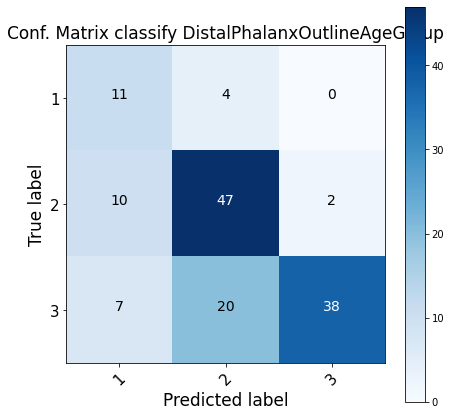

In [233]:
print(len(corpus_train), len(corpus_test))
pred_l, real_l = predict_ucr_test(corpus_train, corpus_test, l_train, l_test, vocabulary,
                                 n_components=3)
print(len(pred_l), len(real_l))
plot_ucr_test_results(pred_l, real_l, key)

In [275]:
def face_four_data(data_path):
    key = "DistalPhalanxOutlineAgeGroup"
#     key = "FaceFour"
    train_file = os.path.join(data_path, key, key+"_TRAIN.tsv")
    test_file = os.path.join(data_path, key, key+"_TEST.tsv")
    file = open(train_file, 'r')
    lines = file.readlines()
    d_train = []
    t_train = []
    l_train = []
    for d in lines:
        arr = d[:-1].split("\t")
        data = np.array(arr[1:], dtype=float)
        times = np.arange(data.size, dtype=float)
        d_train.append(data)
        t_train.append(times)
        l_train.append(int(arr[0]))
        
    file = open(test_file, 'r')
    lines = file.readlines()
    d_test = []
    t_test = []
    l_test = []
    for d in lines:
        arr = d[:-1].split("\t")
        data = np.array(arr[1:], dtype=float)
        times = np.arange(data.size, dtype=float)
        d_test.append(data)
        t_test.append(times)
        l_test.append(int(arr[0]))
        
    return d_train, d_test, t_train, t_test, l_train, l_test

data_path = os.path.join(main_path, "data", "UCRArchive_2018")
d_train_ff, d_test_ff, t_train_ff, t_test_ff, l_train_ff, l_test_ff = face_four_data(data_path)
print("dataset size:", len(d_train_ff), len(d_test_ff))
print("max time:", t_train_ff[0][-1])

alph_size = 4
word_length = [1]
windows = [22]
feature= ["trend_value"]
thresholds = [0] * len(word_length)
empty_handler = "linear_interpolation"
tol = 1
bp_strategy = "normal"
global_break_points = False
numerosity_reduction=True


max_alph_size = alph_size * len(word_length) * len(windows) * len(feature)
full_alphabet = get_full_alphabet(max_alph_size)
doc = generalized_document_transform(d_train_ff[0], t_train_ff[0], full_alphabet,  
                                             alph_size=alph_size, word_length=word_length, 
                                             windows=windows, feature=feature, 
                                             thresholds=thresholds, empty_handler=empty_handler, 
                                             tol=tol, bp_strategy=bp_strategy, 
                                             global_break_point=global_break_points, 
                                             numerosity_reduction=numerosity_reduction)
print(doc['doc'])

dataset size: 400 139
max time: 79.0
['db da db da ca cb']


In [297]:
%%time
data_path = os.path.join(main_path, "data", "plasticc_subsets", "ddf_wdf_split_min_detection", "3_min")
key = "ddf"
train_base = key + "_train_%s.npy"
test_base = key + "_test_%s.npy"
d_train, t_train, l_train, n_train = load_numpy_dataset(data_path, train_base)
d_test, t_test, l_test, n_test = load_numpy_dataset(data_path, test_base)

CPU times: user 185 ms, sys: 6.17 ms, total: 192 ms
Wall time: 185 ms


842.819399999993


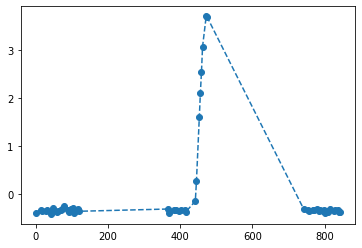

In [298]:
i =0
i = 104
plt.plot(t_test[i] - t_test[i][0], d_test[i], 'o--')
print(t_test[i][-1] - t_test[i][0])

'cd cd cd cd cd ce be be be be bf bf bf bf bf bf bf bf bf bf bf cf cf cf cf df df df df df mk ml ml ml mk mj mj mj mj nk nk nk nk nk nk nk ok ok jo jn jn jn jn jn jn jn jn in in in in in in sv tw tx tu uu uu AD AE BE AE AE AD AD AD AD BD CB BC BC BC BC BC BC CB CB BD BD BD BD CC CC JJ IL IL JM JM IL IM IM IK IK GJ LH JI KI KI HL HM IL KL KI LI LH KM JM JM JM HK KK LK LK PQ'


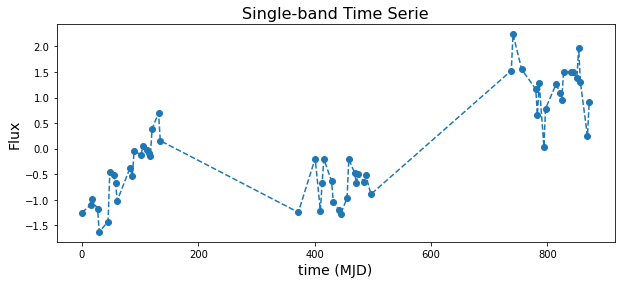

In [210]:
# %%time
alph_size=8
word_length = 2
windows = [800, 400, 200, 100, 50, 25]
feature = "mean"
threshold = 0
i = 204
plt.figure(figsize=(10, 4))
plt.plot(t_train[i] - t_train[i][0], d_train[i], 'o--')
plt.xlabel("time (MJD)", fontsize=14)
plt.ylabel("Flux", fontsize=14)
plt.title("Single-band Time Serie", fontsize=16)

doc0 = multi_window_document(d_train[i], t_train[i], windows, i,
                          alph_size=alph_size, word_length=word_length, 
                          feature=feature, threshold=threshold, bp_strategy="uniform", 
                          tol=2, global_break_points=False)
# vocabulary
new_doc0 = document_numerosity_reduction(doc0)
print("'%s'" % doc0)
# print(new_doc0)

In [211]:
alph_size=8
word_length = 2
windows = [800, 400, 200, 100, 50, 25]
# windows = [800, 400, 200, 100, 50, 25]
feature = "mean"
threshold = 0
tol = 3
# tol = 1
n_components = 20
k = len(windows) * alph_size
full_alphabet = list(string.ascii_lowercase)
full_alphabet.extend(list(string.ascii_uppercase))
vocabulary = []
for k in range(len(windows)):
    used_alphabet = full_alphabet[k*alph_size:(k+1)*alph_size]
    if threshold > 0:
        used_alphabet.append('#')
    vocabulary.extend(list(map(''.join,
                              chain.from_iterable(product(used_alphabet,
                                                         repeat=word_length) for i in range(1)))))
vocabulary = np.unique(vocabulary)
print(full_alphabet[:(k+1)*alph_size])
# vocabulary = np.unique(vocabulary)
if word_length == 1:
    print(vocabulary)
else:
    print("len vocabulary: ", len(vocabulary))
# print(vocabulary)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
len vocabulary:  384


In [212]:
%%time
corpus = []
for j in range(n_train):
#     print(j, end="\r")
    doc = multi_window_document(d_train[j], t_train[j], windows, j,
                          alph_size=alph_size, word_length=word_length, 
                          feature=feature, threshold=threshold, bp_strategy="uniform", 
                          tol=tol, global_break_points=False)
#     doc = document_numerosity_reduction(doc)
    corpus.append(doc)

CPU times: user 12.1 s, sys: 255 ms, total: 12.4 s
Wall time: 12.1 s


In [213]:
%%time
corpus2 = []
for j in range(n_test):
#     print(j, end="\r")
    doc = multi_window_document(d_test[j], t_test[j], windows, j, 
                          alph_size=alph_size, word_length=word_length, 
                          feature=feature, threshold=threshold, bp_strategy="uniform", 
                          tol=tol, global_break_points=False)
#     doc = document_numerosity_reduction(doc)
    corpus2.append(doc)

CPU times: user 8.06 s, sys: 294 ms, total: 8.35 s
Wall time: 8.02 s


(338, 20)
balanced accuracy [PCA, 20 features, ddf survey]:  0.6633399209486166
Confusion matrix, without normalization
balanced accuracy [no-PCA, 384 features, ddf survey]:  0.6076785533307272
Confusion matrix, without normalization


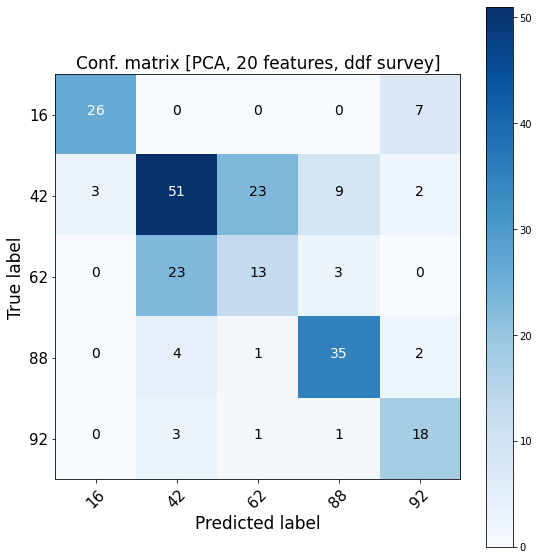

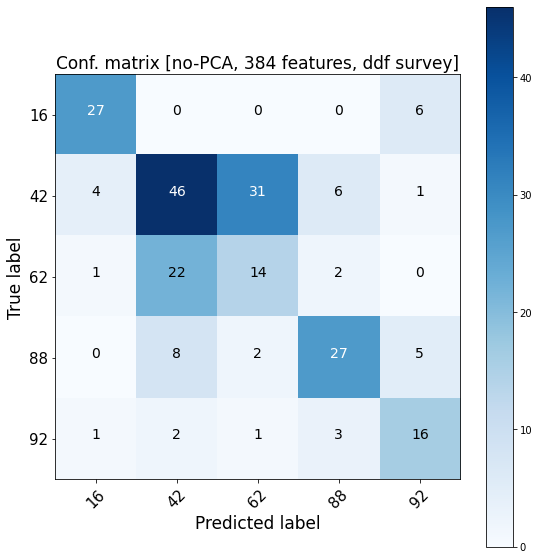

In [214]:
scaler = True
svd = False
with_mean = False

analyzer = "word" if word_length > 1 else "char"
vect = CountVectorizer(lowercase=False, vocabulary=vocabulary, analyzer=analyzer)

X = vect.fit_transform(corpus)
X2 = vect.transform(corpus2)

transf = TfidfTransformer()
tf_idf = transf.fit_transform(X)
tf_idf2 = transf.transform(X2)
tf_idf.shape

tf_idf = tf_idf.todense()
tf_idf2 = tf_idf2.todense()

# discard this normalization
if scaler:
    std_scaler = StandardScaler(with_mean=with_mean)
    tf_idf = std_scaler.fit_transform(tf_idf)
    tf_idf2 = std_scaler.transform(tf_idf2)

# we dont normalize since tf-idf is a normalization
n_com = min(n_components-0, n_train, n_test, tf_idf.shape[1]-1)
key2 = "SVD"
if svd:
    pca = TruncatedSVD(n_components=n_com, n_iter=20)
else:
    key2 = "PCA"
    pca = PCA(n_components=n_com)
    
tf_idf_pca = pca.fit_transform(tf_idf_scaled)
tf_idf2_pca = pca.transform(tf_idf2_scaled)
print(tf_idf_pca.shape)

cos_sim = cosine_similarity(tf_idf_pca, tf_idf2_pca)
cos_pred = predict_class_cosine(cos_sim, l_train, n_train, n_test)
cos_acc = balanced_accuracy_score(l_test, cos_pred)
conf = confusion_matrix(l_test, cos_pred)
print("balanced accuracy [%s, %d features, %s survey]: " % (key2, n_com, key),  cos_acc)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf, classes=np.unique(l_train), normalize=False, 
                     title= "Conf. matrix [%s, %d features, %s survey]" % (key2, n_com, key))

cos_sim = cosine_similarity(tf_idf, tf_idf2)
cos_pred = predict_class_cosine(cos_sim, l_train, n_train, n_test)
cos_acc = balanced_accuracy_score(l_test, cos_pred)
conf = confusion_matrix(l_test, cos_pred)
print("balanced accuracy [no-%s, %d features, %s survey]: " % (key2, tf_idf.shape[1], key),  cos_acc)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf, classes=np.unique(l_train), normalize=False, 
                     title= "Conf. matrix [no-%s, %d features, %s survey]" % (key2, tf_idf.shape[1], key))

## Single band plasticc Dataset evaluations

### Dataset: 5 or more detections, all classes, not augmented

In [293]:
data_path = os.path.join(main_path, "data", "plasticc_subsets", "ddf_wdf_split_min_detection", "5_min")
key = "wdf"
file_base = key + "_%s.npy"
dataset, times, labels, n = load_numpy_dataset2(data_path, file_base, normalize=False)

alph_size = 8
word_length = [1, 2]
windows = [800, 400, 200, 100]
feature= ["mean"]
thresholds = [0, 0]
empty_handler = "special_character"
tol = 2
n_components = 20
bp_strategy = "uniform"
global_break_point = True
similarity="euclidean"

pred, real, X = leave_one_out_classify(dataset, times, labels, alph_size=alph_size, word_length=word_length,
                      windows=windows, feature=feature, thresholds=thresholds, 
                      empty_handler=empty_handler, tol=tol, n_components=n_components,
                      bp_strategy=bp_strategy, global_break_point=global_break_point)

parameters:
word_length= [1, 2]
windows= [800, 400, 200, 100]
features= ['mean']
alph_size=8, n_components=20
full alphabet size:  104
vocabulary size:  288
generating documents from time series dataset ->1196/1196 [DONE], time: 12.112592935562134
generating count vectorizer from each document -> DONE, shape: (1196, 286)


0.2669268020024465
Confusion matrix, without normalization


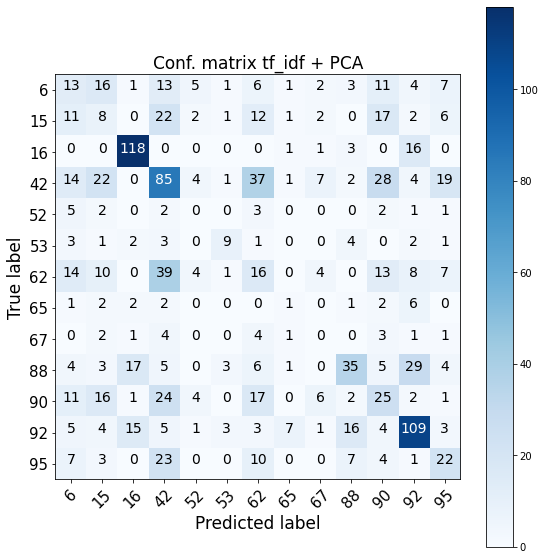

In [300]:
acc = balanced_accuracy_score(real, pred)
print(acc)
conf = confusion_matrix(real, pred)
# print("balanced accuracy [no-%s, %d features, %s survey]: " % (key2, tf_idf.shape[1], key),  cos_acc)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf, classes=np.unique(labels), normalize=False, 
                     title= "Conf. matrix tf_idf + PCA")

In [291]:
data_path = os.path.join(main_path, "data", "plasticc_subsets", "ddf_wdf_split_min_detection", "5_min")
key = "wdf"
file_base = key + "_%s.npy"
dataset, times, labels, n = load_numpy_dataset2(data_path, file_base)

dists = np.zeros((len(dataset), len(dataset)))
for i in range(len(dataset)):
    for j in range(len(dataset)):
        dists[i][j] = dtw.distance_fast(dataset[i], dataset[j])

0.35005962519830125
Confusion matrix, without normalization


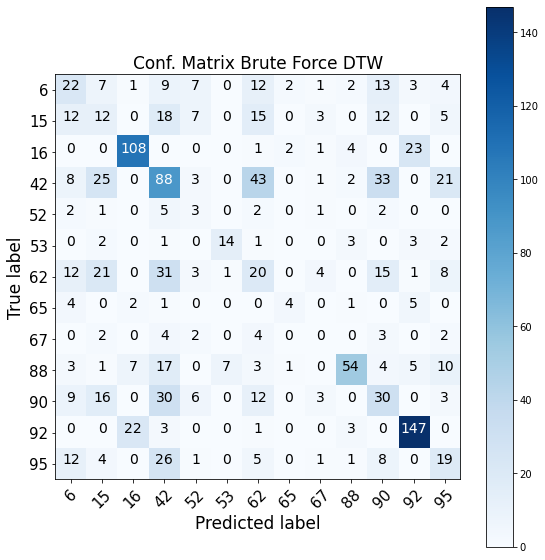

In [292]:
pred_labels = []
for k in range(len(dataset)):
    dists_k = dists[k]
    sorted_idx = np.argsort(dists_k)
    if sorted_idx[0] != k:
        print("fail")
    pred_labels.append(labels[sorted_idx[1]])


acc = balanced_accuracy_score(labels, pred_labels)
print(acc)
conf = confusion_matrix(labels, pred_labels)
# print("balanced accuracy [no-%s, %d features, %s survey]: " % (key2, tf_idf.shape[1], key),  cos_acc)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf, classes=np.unique(labels), normalize=False, 
                     title= "Conf. Matrix Brute Force DTW")


### Dataset: 3 detection or more, reduced to 5 classes, not augmented

In [443]:
main_path = os.path.abspath(os.path.join(os.path.dirname("./Untitled.ipynb"), '..'))
data_path = os.path.join(main_path, "data", "plasticc_subsets", "ddf_wdf_split_min_detection", "3_min")
key = "ddf"
train_base = key + "_train_%s.npy"
test_base = key + "_test_%s.npy"
d_train, t_train, l_train, n_train = load_numpy_dataset(data_path, train_base)
d_test, t_test, l_test, n_test = load_numpy_dataset(data_path, test_base)


dataset1 = list(d_train)
dataset1.extend(list(d_test))
times1 = list(t_train)
times1.extend(list(d_test))
labels1 = list(l_train)
labels1.extend(list(l_test))
labels1 = np.array(labels1)

alph_size = 8
word_length = [2]
windows = [800, 400, 200, 100]
feature= ["mean"]
thresholds = [0]
empty_handler = "special_character"
tol = 3
bp_strategy = "uniform"
global_break_points = False
numerosity_reduction=False

corpus1, vocabulary1 = dataset_to_corpus(dataset1, times1, alph_size=alph_size, 
                                       word_length=word_length, windows=windows,
                                       feature=feature, thresholds=thresholds, 
                                       empty_handler=empty_handler, tol=tol, 
                                       bp_strategy=bp_strategy, 
                                       global_break_point=global_break_points,
                                       numerosity_reduction=numerosity_reduction)

corpus_train1, vocabulary_train1 = dataset_to_corpus(d_train, t_train, alph_size=alph_size, 
                                       word_length=word_length, windows=windows,
                                       feature=feature, thresholds=thresholds, 
                                       empty_handler=empty_handler, tol=tol, 
                                       bp_strategy=bp_strategy, 
                                       global_break_point=global_break_points,
                                       numerosity_reduction=numerosity_reduction)

corpus_test1, vocabulary_test1 = dataset_to_corpus(d_test, t_test, alph_size=alph_size, 
                                       word_length=word_length, windows=windows,
                                       feature=feature, thresholds=thresholds, 
                                       empty_handler=empty_handler, tol=tol, 
                                       bp_strategy=bp_strategy, 
                                       global_break_point=global_break_points,
                                       numerosity_reduction=numerosity_reduction)



transformation parameters:
word_length= [2]
windows= [800, 400, 200, 100]
features= ['mean']
alph_size= 8
full alphabet size:  52
vocabulary size:  256
generating documents from time series dataset ->563/563 [DONE], time: 11.174785375595093
transformation parameters:
word_length= [2]
windows= [800, 400, 200, 100]
features= ['mean']
alph_size= 8
full alphabet size:  52
vocabulary size:  256
generating documents from time series dataset ->338/338 [DONE], time: 7.500756740570068
transformation parameters:
word_length= [2]
windows= [800, 400, 200, 100]
features= ['mean']
alph_size= 8
full alphabet size:  52
vocabulary size:  256
generating documents from time series dataset ->225/225 [DONE], time: 6.1209940910339355


starting leave one out, pipeline: normalize -> PCA -> classify => 40/40
train-test classify balanced accuracy score:  0.7338990719425502
Cross-Validation classify balanced accuracy score:  0.4841727552523446


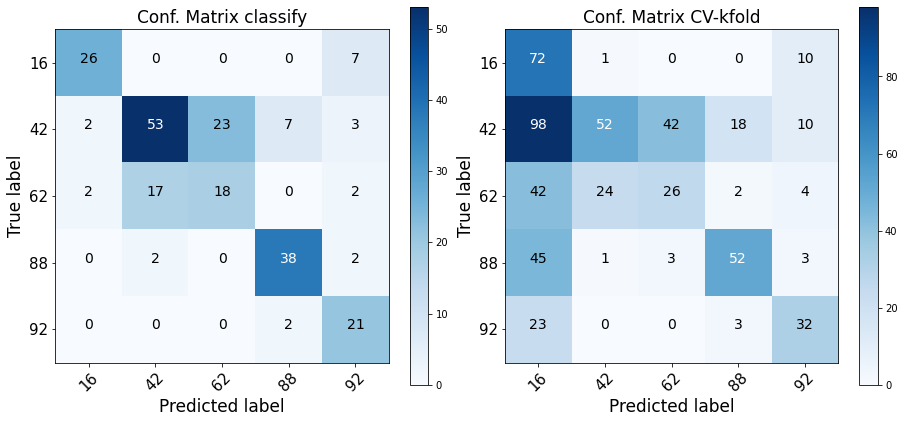

In [449]:
assert all(vocabulary_train1 == vocabulary_test1)

n_components = 22
scaled = True
with_mean = True
similarity = "euclidean"
dim_reducer = "pca"
use_centroids = True
n_iter = 20
cv_strategy = "kfold"
n_splits = 40

pred_labels1, real_labels1 = train_test_classify(corpus_train1, corpus_test1, l_train, l_test,
                        vocabulary=vocabulary_train1, n_components=n_components, scaled=scaled, 
                        with_mean=with_mean, similarity=similarity, dim_reducer=dim_reducer, 
                        use_centroids=use_centroids, n_iter=n_iter)

pred_labels2, real_labels2 = cross_validation_classify(corpus1, labels1, vocabulary=vocabulary1, 
                                                      n_components=n_components, scaled=scaled,
                                                      cv_strategy=cv_strategy, n_splits=n_splits,
                                                      n_iter=n_iter, use_centroids=use_centroids)


acc1 = balanced_accuracy_score(real_labels1, pred_labels1)
print("train-test classify balanced accuracy score: ", acc1)
acc2 = balanced_accuracy_score(real_labels2, pred_labels2)
print("Cross-Validation classify balanced accuracy score: ", acc2)
conf1 = confusion_matrix(real_labels1, pred_labels1)
conf2 = confusion_matrix(real_labels2, pred_labels2)
fig = plt.figure(figsize=(13, 6))

fig.add_subplot(121)
plot_confusion_matrix(conf1, classes=np.unique(l_train), normalize=False, 
                     title= "Conf. Matrix classify")

fig.add_subplot(122)
plot_confusion_matrix(conf2, classes=np.unique(labels1), normalize=False, 
                     title= "Conf. Matrix CV-%s" % cv_strategy)



## Regular datasets

### ControlChart

In [452]:
def control_chart_data():
    file_path = "/home/frmunoz/Documents/tesis/data/synthetic_control.data"
    file = open(file_path, 'r')
    lines = file.readlines()
    dataset = []
    labels = []
    times = []
    class_number = 0
    for i, d in enumerate(lines):
        if i % 100 == 0:
            class_number += 1     
        arr = d[:-1].split()
        y = np.array(arr, dtype=float)
        labels.append(class_number)
        t = np.arange(len(y))
        dataset.append(y)
        times.append(t)
        
    return dataset, times, np.array(labels)
    
cc_d, cc_t, cc_l = control_chart_data()

d_train_cc, d_test_cc, t_train_cc, t_test_cc, l_train_cc, l_test_cc = train_test_split(cc_d, cc_t, cc_l, 
                                                                                         test_size=0.40, 
                                                                                         random_state=42, 
                                                                                         stratify=cc_l)


In [29]:
alph_size = 8
word_length = [1, 2, 3]
windows = [60, 30, 15, 7]
feature= ["mean"]
thresholds = [0, 0, 0]
empty_handler = "special_character"
tol = 2
bp_strategy = "normal"
global_break_points = False
numerosity_reduction=False


corpus_cc, vocabulary_cc = dataset_to_corpus(cc_d, cc_t, alph_size=alph_size, 
                                       word_length=word_length, windows=windows,
                                       feature=feature, thresholds=thresholds, 
                                       empty_handler=empty_handler, tol=tol, 
                                       bp_strategy=bp_strategy, 
                                       global_break_point=global_break_points,
                                       numerosity_reduction=numerosity_reduction)

corpus_cc_train, vocabulary_cc_train = dataset_to_corpus(d_train_cc, t_train_cc, alph_size=alph_size, 
                                       word_length=word_length, windows=windows,
                                       feature=feature, thresholds=thresholds, 
                                       empty_handler=empty_handler, tol=tol, 
                                       bp_strategy=bp_strategy, 
                                       global_break_point=global_break_points,
                                       numerosity_reduction=numerosity_reduction)

corpus_cc_test, vocabulary_cc_test = dataset_to_corpus(d_test_cc, t_test_cc, alph_size=alph_size, 
                                       word_length=word_length, windows=windows,
                                       feature=feature, thresholds=thresholds, 
                                       empty_handler=empty_handler, tol=tol, 
                                       bp_strategy=bp_strategy, 
                                       global_break_point=global_break_points,
                                       numerosity_reduction=numerosity_reduction)

NameError: name 'cc_d' is not defined

starting leave one out, pipeline: normalize -> PCA -> classify => 40/40
train-test classify balanced accuracy score:  0.9833333333333334
Cross-Validation classify balanced accuracy score:  0.9733333333333333


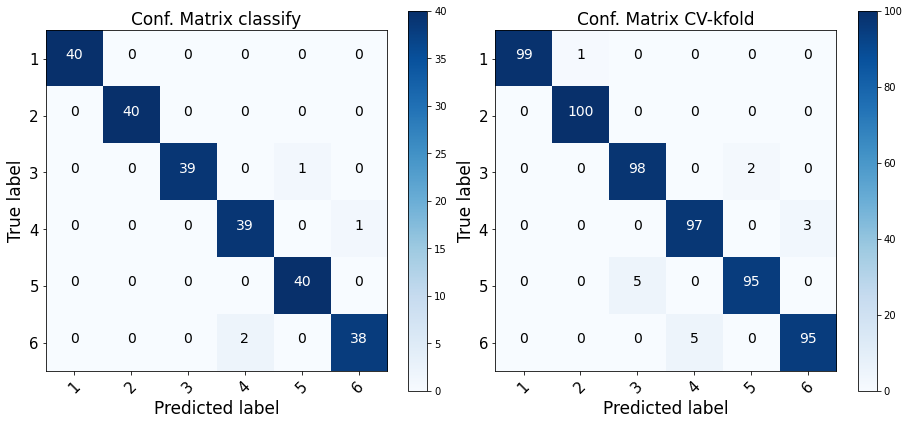

In [461]:
assert all(vocabulary_train1 == vocabulary_test1)

n_components = 22
scaled = True
with_mean = True
similarity = "euclidean"
dim_reducer = "pca"
use_centroids = True
n_iter = 20
cv_strategy = "kfold"
n_splits = 40

pred_l_cc, real_l_cc = train_test_classify(corpus_cc_train, corpus_cc_test, l_train_cc, l_test_cc,
                        vocabulary=vocabulary_cc_train, n_components=n_components, scaled=scaled, 
                        with_mean=with_mean, similarity=similarity, dim_reducer=dim_reducer, 
                        use_centroids=use_centroids, n_iter=n_iter)

pred_l_cv_cc, real_l_cv_cc = cross_validation_classify(corpus_cc, cc_l, vocabulary=vocabulary_cc, 
                                                      n_components=n_components, scaled=scaled,
                                                      cv_strategy=cv_strategy, n_splits=n_splits,
                                                      n_iter=n_iter, use_centroids=use_centroids)


acc1 = balanced_accuracy_score(real_l_cc, pred_l_cc)
print("train-test classify balanced accuracy score: ", acc1)
acc2 = balanced_accuracy_score(real_l_cv_cc, pred_l_cv_cc)
print("Cross-Validation classify balanced accuracy score: ", acc2)
conf1 = confusion_matrix(real_l_cc, pred_l_cc)
conf2 = confusion_matrix(real_l_cv_cc, pred_l_cv_cc)
fig = plt.figure(figsize=(13, 6))

fig.add_subplot(121)
plot_confusion_matrix(conf1, classes=np.unique(l_train_cc), normalize=False, 
                     title= "Conf. Matrix classify")

fig.add_subplot(122)
plot_confusion_matrix(conf2, classes=np.unique(cc_l), normalize=False, 
                     title= "Conf. Matrix CV-%s" % cv_strategy)

### FaceFour

In [90]:
def face_four_data(data_path):
    train_file = os.path.join(data_path, "FaceFour", "FaceFour_TRAIN.tsv")
    test_file = os.path.join(data_path, "FaceFour", "FaceFour_TEST.tsv")
    file = open(train_file, 'r')
    lines = file.readlines()
    d_train = []
    t_train = []
    l_train = []
    for d in lines:
        arr = d[:-1].split("\t")
        data = np.array(arr[1:], dtype=float)
        times = np.arange(data.size, dtype=float)
        d_train.append(data)
        t_train.append(times)
        l_train.append(int(arr[0]))
        
    file = open(test_file, 'r')
    lines = file.readlines()
    d_test = []
    t_test = []
    l_test = []
    for d in lines:
        arr = d[:-1].split("\t")
        data = np.array(arr[1:], dtype=float)
        times = np.arange(data.size, dtype=float)
        d_test.append(data)
        t_test.append(times)
        l_test.append(int(arr[0]))
        
    return d_train, d_test, t_train, t_test, l_train, l_test

data_path = os.path.join(main_path, "data", "UCRArchive_2018")
d_train_ff, d_test_ff, t_train_ff, t_test_ff, l_train_ff, l_test_ff = face_four_data(data_path)
print("dataset size:", len(d_train_ff), len(d_test_ff))
print("max time:", t_train_ff[0][-1])

dataset size: 24 88
max time: 349.0


In [96]:
alph_size = 4
word_length = [4]
windows = [350, 175, 88, 44, 22]
feature= ["mean"]
thresholds = [4] * len(word_length)
empty_handler = "linear_interpolation"
tol = 1
bp_strategy = "normal"
global_break_points = False
numerosity_reduction=True


max_alph_size = alph_size * len(word_length) * len(windows) * len(feature)
full_alphabet = get_full_alphabet(max_alph_size)
doc = generalized_document_transform(d_train_ff[0], t_train_ff[0], full_alphabet,  
                                             alph_size=alph_size, word_length=word_length, 
                                             windows=windows, feature=feature, 
                                             thresholds=thresholds, empty_handler=empty_handler, 
                                             tol=tol, bp_strategy=bp_strategy, 
                                             global_break_point=global_break_points, 
                                             numerosity_reduction=numerosity_reduction)
print(doc)


# if __name__ == "__main__":
if False:
#     corpus_ff, vocabulary_ff = dataset_to_corpus_mp(d_ff, t_ff, n_process=None, alph_size=alph_size, 
#                                        word_length=word_length, windows=windows,
#                                        feature=feature, thresholds=thresholds, 
#                                        empty_handler=empty_handler, tol=tol, 
#                                        bp_strategy=bp_strategy, 
#                                        global_break_point=global_break_points,
#                                        numerosity_reduction=numerosity_reduction)

    corpus_ff_train, vocabulary_ff_train = dataset_to_corpus_mp(d_train_ff, t_train_ff, n_process=None,
                                                                alph_size=alph_size, 
                                       word_length=word_length, windows=windows,
                                       feature=feature, thresholds=thresholds, 
                                       empty_handler=empty_handler, tol=tol, 
                                       bp_strategy=bp_strategy, 
                                       global_break_point=global_break_points,
                                       numerosity_reduction=numerosity_reduction)

    corpus_ff_test, vocabulary_ff_test = dataset_to_corpus_mp(d_test_ff, t_test_ff, n_process=None,
                                                              alph_size=alph_size, 
                                       word_length=word_length, windows=windows,
                                       feature=feature, thresholds=thresholds, 
                                       empty_handler=empty_handler, tol=tol, 
                                       bp_strategy=bp_strategy, 
                                       global_break_point=global_break_points,
                                       numerosity_reduction=numerosity_reduction)
    

# corpus_ff = list(np.copy(corpus_ff_train))
# corpus_ff.extend(corpus_ff_test)
# l_ff = list(np.copy(l_train_ff))
# l_ff.extend(l_test_ff)

# l_ff = np.array(l_ff)
# l_train_ff = np.array(l_train_ff)
# l_test_ff = np.array(l_test_ff)
    
# print("dataset size: ", len(corpus_ff), len(corpus_ff_train), len(corpus_ff_test))

bcbc bccc bcbc bbbc bcbc ccbc cbbc ccbc bcbc bccc bbcc cbbc cbbd cbcd cbcc cbbb cbcc bbcc cbcc bbcc cbcc cbbb bcbb bccc bbcc bccc bcdd bccc cbbb bccc cbbb bccc bddd bbbb cccc fggf fggg ffgg gfgg gfgf ffgf ffgg fggg fgfg fggg ffgg fggg fgfg fgff fggf gggf gfgf gggf gfgf gggf gfgf gfff ggff ggfg ggff ggfg fgfg fffg gffg gfgg gffg gfgg gfgf gfgg ffgg ffgh fggg ffgg fggg fgff fggg fghh fggg gfff fggg fhhh ffff gggg kjlj jjlj jjkj jkkj jkjj jljj jlij jlik jljk jkjk kkjk kjjk ljjj lijj lijk kikk kjkk jjkk ikkk ikkj jkkj jkkk jjkk jkkk jkjk kkjj kkjk kkjj kjkj jjkj jkkj kkkj kjjj kjkj kkkj kkjj jkkj jkkk jkjk jjjk jjjl kjjl jjjk jjkk kjkj jjkj jjlj jjli jkli kkli kkki kkkj jkjj jljj kljj kkjj kkik kkjk kjjk kjjj ljjj kjkj kikj kjkj kjkk kjkj jjkj jjkk jkkk jkjk ikjk jkjk jkjl jkjk jjjk jjkk kjkk kjkj kjkk jjkk jkkk jkjl jkjj jkkk jjkk kjll kjjj jkkk kjjj jkkk jlll jjjj kkkk pnnn onnn onno nnnp nmnp nmop nmpo nnpo nnpn nnpm nopm npom npnm opmm opmn pomn pnmn pmnn pmno omoo omop nmop mnop mooo 

starting leave one out, pipeline: normalize -> PCA -> classify => 10/10
train-test classify balanced accuracy score:  1.0
Cross-Validation classify balanced accuracy score:  1.0


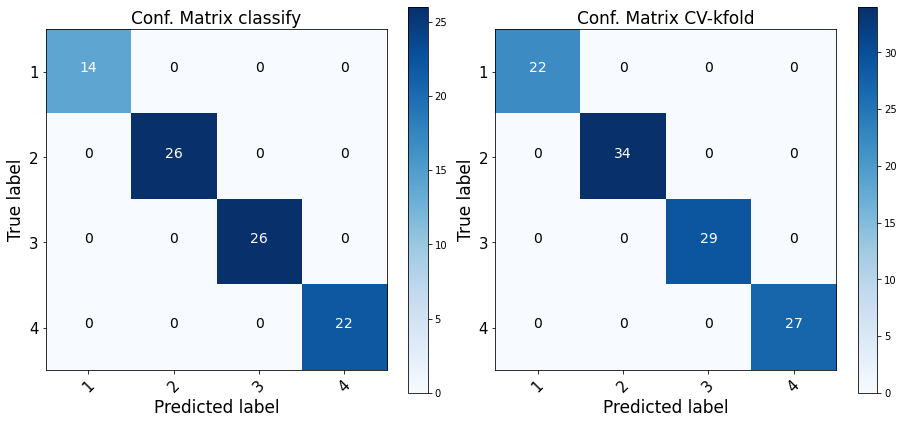

In [9]:
n_components = 22
scaled = True
with_mean = True
similarity = "cosine"
dim_reducer = "pca"
use_centroids = True
n_iter = 20
cv_strategy = "kfold"
n_splits = 10

pred_l_ff, real_l_ff = train_test_classify(corpus_ff_train, corpus_ff_test, l_train_ff, l_test_ff,
                        vocabulary=vocabulary_ff_train, n_components=n_components, scaled=scaled, 
                        with_mean=with_mean, similarity=similarity, dim_reducer=dim_reducer, 
                        use_centroids=use_centroids, n_iter=n_iter)

pred_l_cv_ff, real_l_cv_ff = cross_validation_classify(corpus_ff, l_ff, vocabulary=vocabulary_ff_train, 
                                                      n_components=n_components, scaled=scaled,
                                                      cv_strategy=cv_strategy, n_splits=n_splits,
                                                      n_iter=n_iter, use_centroids=use_centroids)


acc1 = balanced_accuracy_score(real_l_ff, pred_l_ff)
print("train-test classify balanced accuracy score: ", acc1)
acc2 = balanced_accuracy_score(real_l_cv_ff, pred_l_cv_ff)
print("Cross-Validation classify balanced accuracy score: ", acc2)

conf1 = confusion_matrix(real_l_ff, pred_l_ff)
conf2 = confusion_matrix(real_l_cv_ff, pred_l_cv_ff)
fig = plt.figure(figsize=(13, 6))

fig.add_subplot(121)
plot_confusion_matrix(conf1, classes=np.unique(l_train_ff), normalize=False, 
                     title= "Conf. Matrix classify")

fig.add_subplot(122)
plot_confusion_matrix(conf2, classes=np.unique(l_ff), normalize=False, 
                     title= "Conf. Matrix CV-%s" % cv_strategy)

### Beetlefly

In [12]:
def beetle_fly_data(data_path):
    key = "BeetleFly"
    train_file = os.path.join(data_path, key, key + "_TRAIN.tsv")
    test_file = os.path.join(data_path, key, key + "_TEST.tsv")
    file = open(train_file, 'r')
    lines = file.readlines()
    d_train = []
    t_train = []
    l_train = []
    for d in lines:
        arr = d[:-1].split("\t")
        data = np.array(arr[1:], dtype=float)
        times = np.arange(data.size, dtype=float)
        d_train.append(data)
        t_train.append(times)
        l_train.append(int(arr[0]))
        
    file = open(test_file, 'r')
    lines = file.readlines()
    d_test = []
    t_test = []
    l_test = []
    for d in lines:
        arr = d[:-1].split("\t")
        data = np.array(arr[1:], dtype=float)
        times = np.arange(data.size, dtype=float)
        d_test.append(data)
        t_test.append(times)
        l_test.append(int(arr[0]))
        
    return d_train, d_test, t_train, t_test, l_train, l_test

data_path = os.path.join(main_path, "data", "UCRArchive_2018")
d_train_bf, d_test_bf, t_train_bf, t_test_bf, l_train_bf, l_test_bf = beetle_fly_data(data_path)
print("dataset size:", len(d_train_bf), len(d_test_bf))
print("max time:", t_train_bf[0][-1])

dataset size: 20 20
max time: 511.0


In [22]:
510/16

31.875

In [ ]:
alph_size = 4
word_length = [1, 2, 3, 4]
windows = [510, 255, 122, 61, 30]
feature= ["mean"]
thresholds = [0] * len(word_length)
empty_handler = "special_character"
tol = 1
bp_strategy = "normal"
global_break_points = False
numerosity_reduction=True


if __name__ == "__main__":
# if False:

    corpus_bf_train, vocabulary_bf_train = dataset_to_corpus_mp(d_train_bf, t_train_bf, n_process=None,
                                                                alph_size=alph_size, 
                                       word_length=word_length, windows=windows,
                                       feature=feature, thresholds=thresholds, 
                                       empty_handler=empty_handler, tol=tol, 
                                       bp_strategy=bp_strategy, 
                                       global_break_point=global_break_points,
                                       numerosity_reduction=numerosity_reduction)

    corpus_bf_test, vocabulary_bf_test = dataset_to_corpus_mp(d_test_bf, t_test_bf, n_process=None,
                                                              alph_size=alph_size, 
                                       word_length=word_length, windows=windows,
                                       feature=feature, thresholds=thresholds, 
                                       empty_handler=empty_handler, tol=tol, 
                                       bp_strategy=bp_strategy, 
                                       global_break_point=global_break_points,
                                       numerosity_reduction=numerosity_reduction)
    

corpus_bf = list(np.copy(corpus_bf_train))
corpus_bf.extend(corpus_bf_test)
l_bf = list(np.copy(l_train_bf))
l_bf.extend(l_test_bf)

l_bf = np.array(l_bf)
l_train_bf = np.array(l_train_bf)
l_test_bf = np.array(l_test_bf)
    
print("dataset size: ", len(corpus_bf), len(corpus_bf_train), len(corpus_bf_test))

In [15]:
l_bf = np.array(l_bf)
l_train_bf = np.array(l_train_bf)
l_test_bf = np.array(l_test_bf)

starting leave one out, pipeline: normalize -> PCA -> classify => 10/10
train-test classify balanced accuracy score:  0.95
Cross-Validation classify balanced accuracy score:  0.925


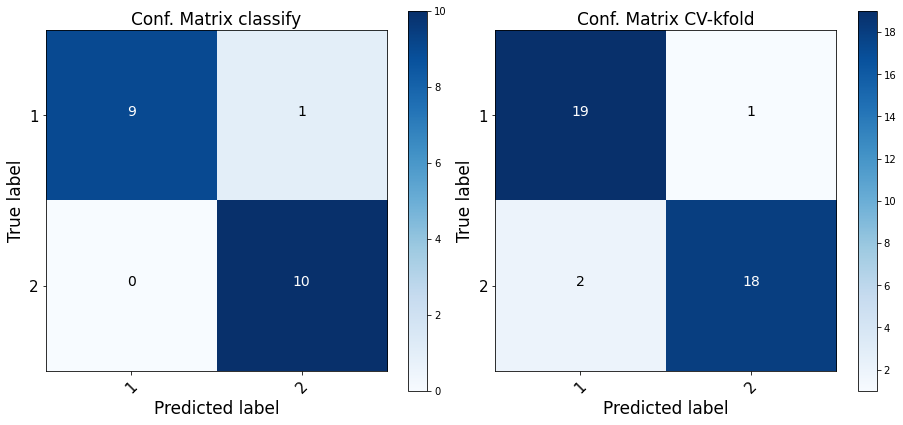

In [37]:
n_components = 22
scaled = True
with_mean = True
similarity = "cosine"
dim_reducer = "pca"
use_centroids = True
n_iter = 20
cv_strategy = "kfold"
n_splits = 10

pred_l_bf, real_l_bf = train_test_classify(corpus_bf_train, corpus_bf_test, l_train_bf, l_test_bf,
                        vocabulary=vocabulary_bf_train, n_components=n_components, scaled=scaled, 
                        with_mean=with_mean, similarity=similarity, dim_reducer=dim_reducer, 
                        use_centroids=use_centroids, n_iter=n_iter)

pred_l_cv_bf, real_l_cv_bf = cross_validation_classify(corpus_bf, l_bf, vocabulary=vocabulary_bf_train, 
                                                      n_components=n_components, scaled=scaled,
                                                      cv_strategy=cv_strategy, n_splits=n_splits,
                                                      n_iter=n_iter, use_centroids=use_centroids)


acc1 = balanced_accuracy_score(real_l_bf, pred_l_bf)
print("train-test classify balanced accuracy score: ", acc1)
acc2 = balanced_accuracy_score(real_l_cv_bf, pred_l_cv_bf)
print("Cross-Validation classify balanced accuracy score: ", acc2)

conf1 = confusion_matrix(real_l_bf, pred_l_bf)
conf2 = confusion_matrix(real_l_cv_bf, pred_l_cv_bf)
fig = plt.figure(figsize=(13, 6))

fig.add_subplot(121)
plot_confusion_matrix(conf1, classes=np.unique(l_train_bf), normalize=False, 
                     title= "Conf. Matrix classify")

fig.add_subplot(122)
plot_confusion_matrix(conf2, classes=np.unique(l_bf), normalize=False, 
                     title= "Conf. Matrix CV-%s" % cv_strategy)

In [24]:
key = "BeetleFly"
pred_l, real_l, pred_l_cv, real_l_cv = test_ucr_dataset(data_path, key)

transformation parameters:
word_length= [1, 2, 3, 4]
windows= [510, 255, 127, 63, 31]
features= ['mean']
alph_size= 4
full alphabet size:  104
vocabulary size:  1700
generating documents using multiprocessing
====> processed 20/20, all workers finished
execution time (sec):  23.500446557998657
transformation parameters:
word_length= [1, 2, 3, 4]
windows= [510, 255, 127, 63, 31]
features= ['mean']
alph_size= 4
full alphabet size:  104
vocabulary size:  1700
generating documents using multiprocessing
====> processed 20/20, all workers finished
execution time (sec):  29.773643732070923
Dimension reduced [1700 => 20]
starting leave one out, pipeline: normalize -> PCA [Dim 1700 => 22]-> classify => 40/40


train-test classify balanced accuracy score:  0.95
Cross-Validation classify balanced accuracy score:  0.925


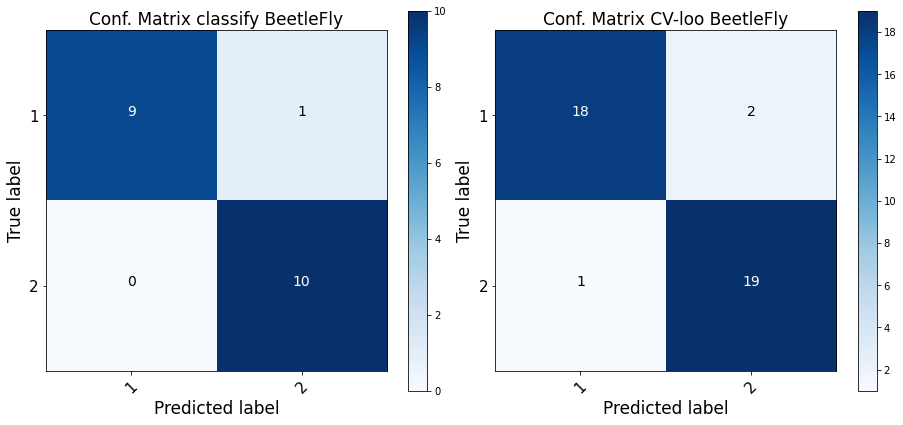

In [25]:
plot_ucr_test_results(pred_l, real_l, pred_l_cv, real_l_cv, key)

### FaceFour

In [26]:
key = "FaceFour"
pred_l, real_l, pred_l_cv, real_l_cv = test_ucr_dataset(data_path, key)

transformation parameters:
word_length= [1, 2, 3, 4]
windows= [350, 175, 87, 43, 21]
features= ['mean']
alph_size= 4
full alphabet size:  104
vocabulary size:  1700
generating documents using multiprocessing
====> processed 24/24, all workers finished
execution time (sec):  20.6149742603302
transformation parameters:
word_length= [1, 2, 3, 4]
windows= [350, 175, 87, 43, 21]
features= ['mean']
alph_size= 4
full alphabet size:  104
vocabulary size:  1700
generating documents using multiprocessing
====> processed 88/88, all workers finished
execution time (sec):  77.30452299118042
Dimension reduced [1700 => 22]
starting leave one out, pipeline: normalize -> PCA [Dim 1700 => 22]-> classify => 112/112


train-test classify balanced accuracy score:  0.9886363636363636
Cross-Validation classify balanced accuracy score:  1.0


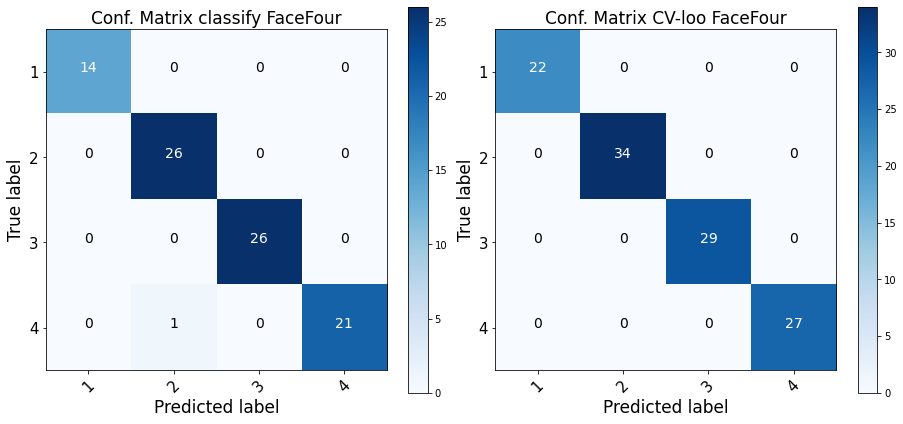

In [27]:
plot_ucr_test_results(pred_l, real_l, pred_l_cv, real_l_cv, key)

### Car

In [19]:
250 / 16, 250 / 32

(15.625, 7.8125)

In [89]:
key = "DistalPhalanxOutlineAgeGroup"
empty_handler = "linear_interpolation"
corpus_train, corpus_test, l_train, l_test, vocabulary = test_ucr_dataset(data_path, key, 
                                                                          alph_size=4,
                                                                         word_length=[1, 2, 3, 4, 5, 6],
                                                                         empty_handler=empty_handler)

transformation parameters:
word_length= [1, 2, 3, 4, 5, 6]
windows= [80, 40, 20, 10, 5]
features= ['mean']
alph_size= 4
full alphabet size:  156
vocabulary size:  27300
generating documents using multiprocessing
=====> Worker failed with error:=====> Worker failed with error:  =====> Worker failed with error: '2''2'=====> Worker failed with error:
 
'2''2'

=====> Worker failed with error: =====> Worker failed with error:'2' 
'2'
=====> Worker failed with error: '2'
=====> Worker failed with error: '2'
====> processed 400/400, all workers finished
execution time (sec):  0.8973095417022705
transformation parameters:
word_length= [1, 2, 3, 4, 5, 6]
windows= [80, 40, 20, 10, 5]
features= ['mean']
alph_size= 4
full alphabet size:  156
vocabulary size:  27300
generating documents using multiprocessing
=====> Worker failed with error:=====> Worker failed with error: =====> Worker failed with error: '2''2'
 
=====> Worker failed with error:=====> Worker failed with error:'2' '2'

=====> Worke

Dimension reduced [27300 => 50]
train-test classify balanced accuracy score:  0.7219469795740983


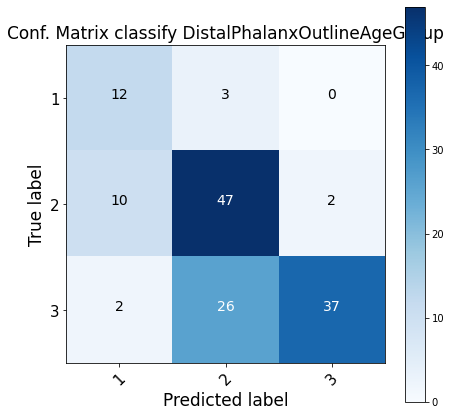

In [88]:
pred_l, real_l = predict_ucr_test(corpus_train, corpus_test, l_train, l_test, vocabulary,
                                 n_components=50)
plot_ucr_test_results(pred_l, real_l, key)

### Haptics

In [496]:
def haptics_data(data_path):
    train_file = os.path.join(data_path, "Haptics", "Haptics_TRAIN.tsv")
    test_file = os.path.join(data_path, "Haptics", "Haptics_TEST.tsv")
    file = open(train_file, 'r')
    lines = file.readlines()
    d_train = []
    t_train = []
    l_train = []
    for d in lines:
        arr = d[:-1].split("\t")
        data = np.array(arr[1:], dtype=float)
        times = np.arange(data.size, dtype=float)
        d_train.append(data)
        t_train.append(times)
        l_train.append(int(arr[0]))
        
    file = open(test_file, 'r')
    lines = file.readlines()
    d_test = []
    t_test = []
    l_test = []
    for d in lines:
        arr = d[:-1].split("\t")
        data = np.array(arr[1:], dtype=float)
        times = np.arange(data.size, dtype=float)
        d_test.append(data)
        t_test.append(times)
        l_test.append(int(arr[0]))
        
    return d_train, d_test, t_train, t_test, l_train, l_test

data_path = os.path.join(main_path, "data", "UCRArchive_2018")
d_train_hap, d_test_hap, t_train_hap, t_test_hap, l_train_hap, l_test_hap = haptics_data(data_path)

d_hap = list(np.copy(d_train_hap))
d_hap.extend(d_test_hap)
t_hap = list(np.copy(t_train_hap))
t_hap.extend(t_test_hap)
l_hap = list(np.copy(l_train_hap))
l_hap.extend(l_test_hap)

l_hap = np.array(l_hap)
l_train_hap = np.array(l_train_hap)
l_test_hap = np.array(l_test_hap)
print("len dataset:", len(d_hap), len(d_train_hap), len(d_test_hap))
print("max time:", t_ff[0][-1])

len dataset: 463 155 308
max time: 349.0


In [494]:
alph_size = 8
word_length = [1, 2, 3]
windows = [350, 175, 88, 44]
feature= ["mean"]
thresholds = [0, 0, 0]
empty_handler = "special_character"
tol = 2
bp_strategy = "normal"
global_break_points = False
numerosity_reduction=False


corpus_hap, vocabulary_hap = dataset_to_corpus(d_hap, t_hap, alph_size=alph_size, 
                                       word_length=word_length, windows=windows,
                                       feature=feature, thresholds=thresholds, 
                                       empty_handler=empty_handler, tol=tol, 
                                       bp_strategy=bp_strategy, 
                                       global_break_point=global_break_points,
                                       numerosity_reduction=numerosity_reduction)

corpus_hap_train, vocabulary_hap_train = dataset_to_corpus(d_train_hap, t_train_hap, alph_size=alph_size, 
                                       word_length=word_length, windows=windows,
                                       feature=feature, thresholds=thresholds, 
                                       empty_handler=empty_handler, tol=tol, 
                                       bp_strategy=bp_strategy, 
                                       global_break_point=global_break_points,
                                       numerosity_reduction=numerosity_reduction)

corpus_hap_test, vocabulary_hap_test = dataset_to_corpus(d_test_hap, t_test_hap, alph_size=alph_size, 
                                       word_length=word_length, windows=windows,
                                       feature=feature, thresholds=thresholds, 
                                       empty_handler=empty_handler, tol=tol, 
                                       bp_strategy=bp_strategy, 
                                       global_break_point=global_break_points,
                                       numerosity_reduction=numerosity_reduction)

transformation parameters:
word_length= [1, 2, 3]
windows= [350, 175, 88, 44]
features= ['mean']
alph_size= 8
full alphabet size:  104
vocabulary size:  2336
generating documents from time series dataset ->463/463 [DONE], time: 1573.0969908237457
transformation parameters:
word_length= [1, 2, 3]
windows= [350, 175, 88, 44]
features= ['mean']
alph_size= 8
full alphabet size:  104
vocabulary size:  2336
generating documents from time series dataset ->463/463 [DONE], time: 1563.6190083026886
transformation parameters:
word_length= [1, 2, 3]
windows= [350, 175, 88, 44]
features= ['mean']
alph_size= 8
full alphabet size:  104
vocabulary size:  2336


KeyboardInterrupt: 

In [441]:
pred_labels = []
for k in range(len(dataset)):
    dists_k = dists[k]
    sorted_idx = np.argsort(dists_k)
    if sorted_idx[0] != k:
        print("fail")
    pred_labels.append(labels[sorted_idx[1]])

In [442]:
balanced_accuracy_score(labels, pred_labels)

0.7320129461019128

### multi-word document representation

In [90]:
# %%time
alph_size=8
word_lengths = [1, 2, 4]
window = 400
feature = "mean"
thresholds = [0, 0, 1]
i = 20
doc0 = multi_word_document(d_train[i], t_train[i], word_lengths, 
                          alph_size=alph_size, window=window, 
                          feature=feature, thresholds=thresholds, bp_strategy="uniform", 
                          tol=2, global_break_points=False)
# vocabulary
new_doc0 = document_numerosity_reduction(doc0)
print(doc0)
print(new_doc0)

f e e e e d d d d d d d d d d e e e e e e e d d d c c d e e d e e e e e e e e f e e gb gb gb gc hc fc fc fd ed ed fd fd de df df de de de ee ee ed ed fc fc fc e#ad e#ad f#ae f#ae cg#e f#ac f#bc
f e d e d c d e d e f e gb gc hc fc fd ed fd de df de ee ed fc e#ad f#ae cg#e f#ac f#bc


In [290]:
alph_size=8
word_lengths = [1, 2, 3]
window = 400
feature = "mean"
thresholds = [1, 2, 3]
tol = 3
n_components = 20
k = len(word_lengths) * alph_size
full_alphabet = list(string.ascii_lowercase)
full_alphabet.extend(list(string.ascii_uppercase))
used_alphabet = full_alphabet[:k]
if max(thresholds) > 0:
    used_alphabet.append('#')
print(used_alphabet)
vocabulary = list(map(''.join, 
         chain.from_iterable(product(used_alphabet, 
                                     repeat=i) for i in [1, 2, 4])))
# vocabulary = np.unique(vocabulary)
if max(word_lengths) == 1:
    print(vocabulary)
else:
    print("len vocabulary: ", len(vocabulary))

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', '#']
len vocabulary:  391275


In [291]:
%%time
corpus3 = []
for j in range(n_train):
#     print(j, end="\r")
    doc = multi_word_document(d_train[j], t_train[j], word_lengths, 
                          alph_size=alph_size, window=window, 
                          feature=feature, thresholds=thresholds, bp_strategy="uniform", 
                          tol=tol, global_break_points=False)
#     doc = document_numerosity_reduction(doc)
    corpus3.append(doc)

CPU times: user 3.71 s, sys: 182 ms, total: 3.89 s
Wall time: 3.66 s


In [292]:
%%time
corpus4 = []
for j in range(n_test):
#     print(j, end="\r")
    doc = multi_word_document(d_test[j], t_test[j], word_lengths, 
                          alph_size=alph_size, window=window, 
                          feature=feature, thresholds=thresholds, bp_strategy="uniform", 
                          tol=tol, global_break_points=False)
#     doc = document_numerosity_reduction(doc)
    corpus4.append(doc)

CPU times: user 2.36 s, sys: 62 ms, total: 2.42 s
Wall time: 2.33 s


In [293]:
%%time
analyzer = "word"

vect = CountVectorizer(lowercase=False, vocabulary=vocabulary, analyzer=analyzer, tokenizer=lambda txt: txt.split())


X3 = vect.fit_transform(corpus3)
X4 = vect.transform(corpus4)

transf = TfidfTransformer()
tf_idf3 = transf.fit_transform(X3)
tf_idf4 = transf.fit_transform(X4)

n_com = min(n_components, n_train, n_test, tf_idf3.shape[1]-1)
pca = TruncatedSVD(n_components=n_com, n_iter=20)
tf_idf3_pca = pca.fit_transform(tf_idf3)
tf_idf4_pca = pca.transform(tf_idf4)

CPU times: user 22.4 s, sys: 21.8 s, total: 44.2 s
Wall time: 6.78 s


0.5091999519234498
Confusion matrix, without normalization


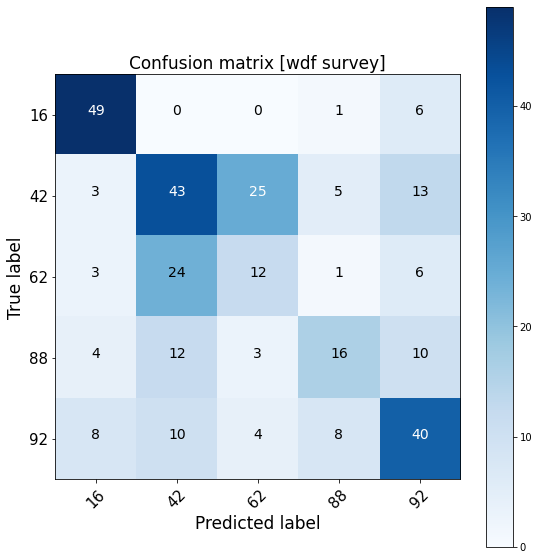

In [294]:
cos_sim = cosine_similarity(tf_idf3_pca, tf_idf4_pca)
cos_pred = predict_class_cosine(cos_sim, l_train, n_train, n_test)
cos_acc = balanced_accuracy_score(l_test, cos_pred)
conf = confusion_matrix(l_test, cos_pred)
print(cos_acc)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf, classes=np.unique(l_train), normalize=False, 
                     title= "Confusion matrix [%s survey]" % key)

0.4556713269903304
Confusion matrix, without normalization


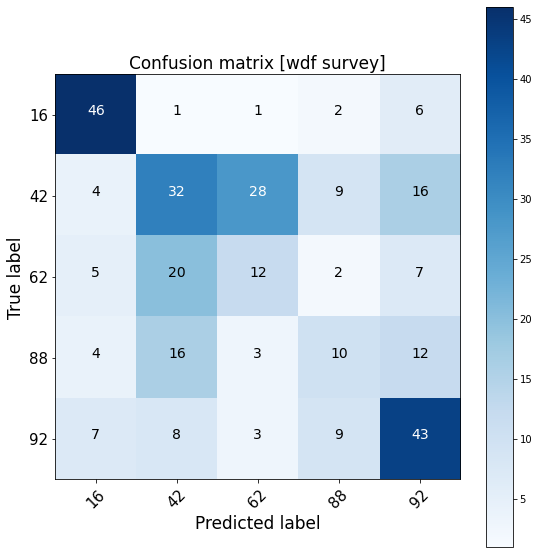

In [295]:
cos_sim = cosine_similarity(tf_idf3, tf_idf4)
cos_pred = predict_class_cosine(cos_sim, l_train, n_train, n_test)
cos_acc = balanced_accuracy_score(l_test, cos_pred)
conf = confusion_matrix(l_test, cos_pred)
print(cos_acc)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf, classes=np.unique(l_train), normalize=False, 
                     title= "Confusion matrix [%s survey]" % key)